In [1]:
import numpy as np
import os
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from keras.models import Sequential
from keras.models import model_from_yaml
from sklearn.utils import shuffle
from keras.layers import Dense
from sklearn import preprocessing
%matplotlib inline
import pandas as pd

from utils import *

Using TensorFlow backend.


### GET DATA

In [2]:
# read data
features_df = pd.read_csv('data.csv')

# get train label and data
all_labels = features_df.values[:,0]
all_labels=all_labels[:]+1
x_data = features_df.values[:,1:]

In [3]:
# get unique labesl
unique_words = set(all_labels)
print(unique_words)

{1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0}


### PREPROCESS DATA

#### Test and train split

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.15, random_state=0)

for train_index, test_index in sss.split(x_data,all_labels):
    X_train, X_test = x_data[train_index], x_data[test_index]
    y_train, y_test = all_labels[train_index], all_labels[test_index]
    

print('Size of training matrix:', X_train.shape)
print('Size of testing matrix:', X_test.shape)

Size of training matrix: (18217, 2808)
Size of testing matrix: (3215, 2808)


#### Normalize data

In [5]:
# normalize train
scaler = preprocessing.StandardScaler().fit(X_train)
X_train=scaler.transform(X_train)

# normalize train
scaler = preprocessing.StandardScaler().fit(X_train)
X_train=scaler.transform(X_train)

#get number of columns in training data
n_cols = x_data.shape[1]

### IMBALANCED DATASET
In this document we train our model by utilizing one vs all apprach. Thefore the data of single label (ones) is considerably low than that of others. Before train our model, we need to fix the imbalance dataset.

In [6]:
#draw chart
def pie_chart(y,label):
    one_shape = y[y==label].shape[0]
    others_shape = y[y!=label].shape[0]
    plt.pie(
        list([one_shape, others_shape]),
        labels=['Label {}: {}'.format(label,one_shape),'{}: {}'.format('others',others_shape)]
    );

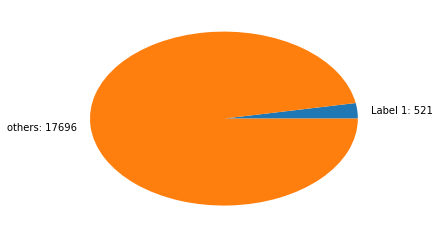

In [7]:
# visualize imbalanced dataset: exmaple for label 1
pie_chart(y_train,1)

#### SMOTE
SMOTE (Synthetic Minority Over-Sampling Technique) is an over-sampling technique that introduces small perturbations to synthetic examples along the direction of existing samples to reduce overfitting. See original paper for detailed explanation of SMOTE.


#### SMOTE Implementation

There is a SMOTE implementation in imblearn package for scikit-learn. However, there is not an option to apply SMOTE with arbitrary percentages (SMOTE-100, SMOTE-300, etc.); it simply balances all the classes. And also since SMOTE is not a hard to implement algorithm, we provide our own implementation.

In [8]:
from sklearn.neighbors import NearestNeighbors
from random import randint


def smote(samples, amount, k=2):
    """
    Apply SMOTE algorithm to samples and return a new samples
    array with synthetically created samples.
    
    Parameters
    ----------
    samples: (n_samples, n_features) samples array to be sent to
             SMOTE algorithm.
    amount: Percentage of newly created synthetic samples. (E.g.
            amount=100 would create as many synthetic examples
            as existing ones).
    k: Number of nearest neighbors in SMOTE algorithm.
    
    Returns
    -------
    out: ((1 + amount/100)*n_samples, n_features) samples array containing
         the original and the newly created synthetic examples.
         
    References
    ----------
    http://www.jair.org/media/953/live-953-2037-jair.pdf
    """
    samples = np.copy(samples)
    n_samples, n_features = samples.shape
    # handle amount < 100 case
    if amount < 100:
        num_samples = int(len(samples)*(amount/100))
        np.shuffle(samples)
        samples = samples[:num_samples, :]
        amount = 100
    amount = int(amount/100)
    synthetic = np.empty((n_samples*amount, n_features))
    # find k nearest neighbors of each point and store it in nnarray
    nbrs = NearestNeighbors(n_neighbors=k + 1).fit(samples)
    _, nnarray = nbrs.kneighbors(samples)
    nnarray = nnarray[:, 1:]  # get rid of self-nearest-neighbor.
    # create synthetic examples and store them in synthetic.
    for i, neighbors in enumerate(nnarray):
        for j in range(amount):
            chosen = neighbors[randint(0, k - 1)]
            diff = samples[chosen] - samples[i]
            gap = np.random.rand(n_features)
            synthetic[i*amount + j] = samples[i] + gap*diff
    out = np.vstack((samples, synthetic))
    
    return out

#### Visualizing Synthetic SMOTE Examples

In [9]:
# generate sample array
arr1 = np.random.normal(loc=5, scale=2.5, size=(200, 2))
arr2 = np.random.normal(loc=0, scale=2.5, size=(70, 2))

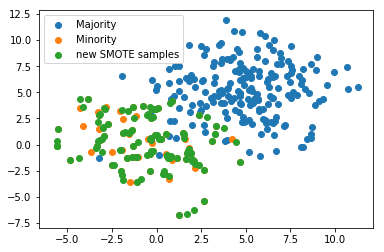

In [10]:
arr_smote = smote(arr2, 100)
plt.scatter(*arr1.T, label='Majority')
plt.scatter(*arr2.T, label='Minority')
plt.scatter(*arr_smote[25:, :].T, label='new SMOTE samples')
plt.legend();

In [11]:
def smote_sampling(X, y, label):

    other_n = y[y!=label].shape[0]
    one_n = y[y==label].shape[0]
    smote_amount = int(((other_n-one_n)*100)/one_n)

    X_one = X[y==label]
    synthetic_data = smote(X_one, smote_amount)
    n_synthetic = len(synthetic_data)

    # merge synthetic examples with original examples
    X_out = np.vstack((X[y!=label], synthetic_data))
    y_out = np.concatenate((y[y!=label], [label]*n_synthetic))

    return X_out, y_out

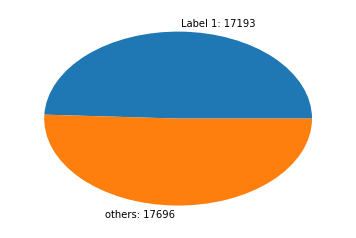

In [12]:
# example for label 1 after upsampling
X_out, y_out = smote_sampling(X_train, y_train, 1)
pie_chart(y_out,1)

In [13]:
def ronadom_undersample(X,y,label):
    X1 = X[y==label]
    y1 = y[y==label]

    # define others labels
    # and reduce theri elements randomly
    X2 = X[y!=label]
    y2 = y[y!=label]
    idx = np.random.choice(np.arange(X2.shape[0]), int(X1.shape[0]*4), replace=False)
    X2_new = X2[idx,:]
    y2_new = y2[idx]

    X_out = np.vstack((X1, X2_new))
    y_out = np.concatenate((y1, y2_new))

    return X_out, y_out

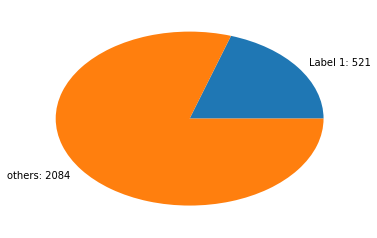

In [14]:
# example for label 1 after undersampling
X_out, y_out = ronadom_undersample(X_train, y_train, 1)
pie_chart(y_out,1)

In [15]:
def multiply_oversmaple(X,y,label):
    
    X1 = X[y==label]
    y1 = y[y==label]

    # define others labels
    # and reduce theri elements randomly
    X2 = X[y!=label]
    y2 = y[y!=label]
    
    X1_new=[X1]*int(X2.shape[0]/X1.shape[0])
    X1_new=np.array(X1_new)
    X1_new=np.resize(X1_new,(X1_new.shape[0]*X1_new.shape[1],X2.shape[1]))
    
    y1_new=[y1]*int(y2.shape[0]/y1.shape[0])
    y1_new=np.array(y1_new)
    y1_new=np.resize(y1_new,(y1_new.shape[0]*y1_new.shape[1]))
                     
                     
    X_out = np.vstack((X1_new, X2))
    y_out = np.concatenate((y1_new, y2))

    return X_out, y_out

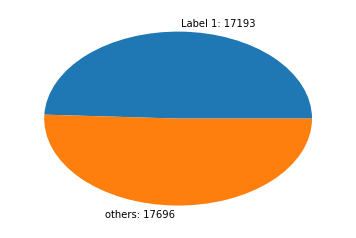

In [16]:
# example for label 1 after upsample
X_out, y_out = multiply_oversmaple(X_train, y_train, 1)
pie_chart(y_out,1)

### TRAINER CLASS

In [17]:
# class to handle NN processing
class NNTrainer(object):  
    '''
    Parameters
    ----------
    
    layer_activation: activation function for input and hidden layers
    covariance_type: activation function of end layer
    input_n_cols: numver of columns of input layer
    optimizer_function: optimization function
    loss_function: loss functions
    metrics_v: metric for evaluation result
    epochs_n: number of epoches to update train weights
    batch_size_n: batch size of fitted data
    validation_split_n: ratio of validation split in traning 
    
    choice of parameters depends on the data. 
    '''
    
    def __init__(self, layer_activation='relu', end_layer_activation='softmax',input_n_cols=2808,
                 optimizer_function='adam',loss_function='categorical_crossentropy',metrics_v='accuracy',
                epochs_n=3, batch_size_n=20, validation_split_n=0.2):
        
        # initialize variables
        self.layer_activation = layer_activation
        self.end_layer_activation = end_layer_activation
        self.input_n_cols = input_n_cols
        self.optimizer_function = optimizer_function
        self.loss_function = loss_function
        self.metrics_v = metrics_v
        self.epochs_n = epochs_n
        self.batch_size_n =batch_size_n
        self.validation_split_n = validation_split_n
        
        
        # define model
        self.model = Sequential()
        #add layers to model and initialize
        self.model.add(Dense(200, activation=self.layer_activation, input_shape=(self.input_n_cols,)))
        self.model.add(Dense(200, activation=self.layer_activation))
        self.model.add(Dense(2, activation=self.end_layer_activation))
        
        # compile model
        self.model.compile(optimizer=self.optimizer_function, 
                           loss=self.loss_function,metrics=[self.metrics_v])
            
    #train mode
    def train(self, X_train, y_train):
        # ingonre divisin by 0
        # np.seterr(all='ignore') 
        #train model
        self.model.fit(X_train, y_train, epochs=self.epochs_n,
                       batch_size=self.batch_size_n,validation_split=self.validation_split_n)
         
    # run the model on new data and get score
    def predict_probability(self, X_test):
        scores = self.model.predict_proba(X_test)
        return scores

    
    # return model
    def model_evaluate(self, X_test, y_test):
        scores = self.model.evaluate(X_test, y_test, verbose=0)
        return scores[1]*100
    
    # save model
    def save_model(self,name):
        # serialize model to YAML
        model_yaml = self.model.to_yaml()
        with open('model_:{}.yaml'.format(name), "w") as yaml_file:
            yaml_file.write(model_yaml)
        # serialize weights to HDF5
        self.model.save_weights('model_:{}.h5'.format(name))
        print("SAVED MODEL: " + str(name))
        

### TRAIN MODELS

Train each model seperately. 

In [2]:
nn_models = [] # list to keep all models
input_n_cols=X_train.shape[1]

### for each model
for label in unique_words:
    
    # random undersampling 
    # X_out, y_out = ronadom_undersample(X_train, y_train, int(label))
    
    # oversmapling smote
    # X_out, y_out = smote_sampling(X_train, y_train, int(label))
    
    # oversampling multiply
    # X_out, y_out = multiply_oversmaple(X_train, y_train, int(label))

    # shullfe data
    # X_out, y_out = shuffle(X_out, y_out, random_state=0)

    # generate traget lables make others zero: one vs all
    target = np.zeros((len(y_train),2),dtype=int)
    for i,l_i in enumerate(y_train):
        if(int(l_i)==int(label)):
            target[i][0]=1
        else: 
            target[i][1]=1
    
    print(int(label))
        
    # train model
    nn_trainer = NNTrainer(input_n_cols=input_n_cols)
    nn_trainer.train(X_test, target)
    
    # append model and save
    nn_models.append((nn_trainer, label))
    nn_trainer.save_model("oversample"+str(int(label)))
    
    with open('./models/models.txt', 'w') as f:
        f.write("name {}\n".format(i))
    
    nn_trainer = None

NameError: name 'X_train' is not defined

### EVALUATE MODELS

Given each test data, we run all the models on it data and pick the one with the best score.

In [76]:
# logprob_1 = np.array([m[0].predict_probability(X_test)[:,0] for m in nn_models])
# predicted_label = np.argmax(logprob_1, axis=1)
# predicted_label=predicted_label+1
# result = (predicted_label == y_test)
# print('Overall test accuracy: %.2f percent' % (100 * (np.mean(result))))

Overall test accuracy: 64.39 percent


In [65]:
# get the model with best score

# as undersample data is marginal reduce the number of test data

logprob_1 = np.array([m[0].predict_probability(X_test)[:,0] for m in nn_models]) ## prob of one gorup
logprob_2 = np.array([m[0].predict_probability(X_test)[:,1] for m in nn_models]) ## prob of others group

In [74]:
logprob_1=logprob_1.T
logprob_2=logprob_2.T

In [67]:
'''
how to evaluate evaluate model:
    select the ones with larget prob.
    if prob of ones are euqal for any model then select the model with min others prob
'''
 
result=np.zeros((y_test.shape[0]), dtype=int)

for i in range(y_test.shape[0]):
    max=-100
    idx=1
    max_min=100
    for j in range(41):
        if logprob_1[i][j]>max and logprob_1[i][j]>logprob_2[i][j]:
            max=logprob_1[i][j]
            max_min=logprob_2[i][j]
            idx=(j+1)
        if logprob_1[i][j]==max and logprob_2[i][j]<max_min:
            max=logprob_1[i][j]
            max_min=logprob_2[i][j]
            idx=(j+1)
            
    # compare result with the actual labels
    if(int(y_test[i])==int(idx)):
        result[i]=1

In [68]:
print('Overall unseen test accuracy: %.2f percent' % (np.mean(result)*100))

Overall unseen test accuracy: 73.37 percent


#### CHECK GENERALIZATION ON DIFFERENT MODELS

In [18]:
# load YAML and create model
yaml_file = open('model_:undersample 4.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
loaded_model = model_from_yaml(loaded_model_yaml)
# load weights into new model
loaded_model.load_weights("model_:undersample 4.h5")
print("Loaded model from disk")

Loaded model from disk


In [77]:
'''
in order to check generalization of model, we'll test data 40(40th word features) on model 1 (1 word's data)
'''
# random undersampling 
# X_out, y_out = ronadom_undersample(X_train, y_train, int(1))

# oversmapling smote
# X_out, y_out = smote_sampling(X_train, y_train, int(1))

# oversampling multiply
X_out, y_out = multiply_oversmaple(X_train, y_train, int(1))

# shullfe data
X_out, y_out = shuffle(X_out, y_out, random_state=0)

target = np.zeros((len(y_out),2),dtype=int)

for i,l_i in enumerate(y_out):
    if(int(l_i)==10):
        target[i][0]=1
    else:         
        target[i][1]=0

In [78]:
model_1_result_41=nn_models[0][0].model_evaluate(X_out,target)
print("%.2f%%" % (model_1_result_41))

48.17%


As it seems not-targeted data on target model outputs a result with a high degree of certainty, 48.17%. This indicates that it models can make good generalization.